# Abalone Dataset Experiments

In [3]:
%pylab inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.linear_model
import sklearn.ensemble
import math

import seaborn as sns

sns.set_context('talk')
sns.set_style('white')

matplotlib.rcParams['pdf.fonttype'] = 42
# latex strings for plots
pareto_exact = r"${\mathcal{P}}_{\mathrm{exact}}$"

Populating the interactive namespace from numpy and matplotlib


In [4]:
# define plotting colors
subset_fracs = [.005, .01,0.1,1.0]
num_colors = len(subset_fracs)

green_colors = sns.cubehelix_palette(num_colors, start=2, rot=0, dark=.3, light=.8)
purple_colors = sns.cubehelix_palette(num_colors, start=0.4, rot=0, dark=.2, light=.8)

all_training_data_color_reg = purple_colors[len(subset_fracs)-1]
all_training_data_color_for = green_colors[len(subset_fracs)-1]


colors_feats_reg = ['dodgerblue', 'orange', all_training_data_color_reg] 
colors_feats_for= ['blue', 'magenta', all_training_data_color_for]


## Function Definitions

In [5]:
def compute_pareto_curves(pred_w, pred_p, true_w, true_p):
    alphas = np.linspace(0,1,200)
    
    welfares = []
    profits = []
    welfares_model = []
    profits_model = []
    welfares_est = []
    profits_est = []
    U_alpha_opt = []; U_w_opt = []; U_p_opt = [];
    U_alpha_model = []; U_w_model = []; U_p_model = []
    
    for alpha in alphas:
        # exact scores
        accept = (1-alpha) * true_p + alpha * true_w > 0
        U_w_opt.append(np.sum(true_w[accept]))
        U_p_opt.append(np.sum(true_p[accept]))
        U_alpha_opt.append( (1-alpha) * np.sum(true_p[accept]) + alpha * np.sum(true_w[accept]))

        # predicted scores
        accept_est = (1-alpha) * pred_p + alpha * pred_w > 0
        U_alpha_model.append( (1-alpha) * np.sum(true_p[accept_est]) + alpha * np.sum(true_w[accept_est]))
        U_w_model.append(np.sum(true_w[accept_est]))
        U_p_model.append(np.sum(true_p[accept_est]))

        welfares_est.append(np.sum(pred_w[accept_est]))
        profits_est.append(np.sum(pred_p[accept_est]))
     
    return {
        'alphas':alphas,
        'U_w_opt': np.array(U_w_opt), 'U_p_opt': np.array(U_p_opt),  'U_alpha_opt': np.array(U_alpha_opt),
        'U_w_model': np.array(U_w_model), 'U_p_model': np.array(U_p_model),  
        'U_alpha_model': np.array(U_alpha_model),
        'U_w_model_est': np.array(welfares_est), 'U_p_model_est': np.array(profits_est)     
    }

In [6]:
from sklearn.model_selection import KFold

def get_model(X, y, method='linreg', drop_features=[], drop_data=None, crit=None, cross_val=True):
    
    rs_ = np.random.RandomState(0)
    if method == 'linreg':
        if cross_val:
            lambdas = np.logspace(-8,2,base=10,num=11)
            num_folds = 4
            kf = KFold(n_splits=num_folds)
            errs = np.zeros((len(lambdas), num_folds))
            for i, (train_idx, test_idx) in enumerate(kf.split(X)):
                for j, lam in enumerate(lambdas):
                    reg_this = sk.linear_model.Ridge(lam).fit(X[train_idx],y[train_idx])
                    preds_this = reg_this.predict(X[test_idx])
                    errs[j,i] = sklearn.metrics.mean_squared_error(y[test_idx], preds_this)
            
            assert len(np.mean(errs,axis=1)) == len(lambdas)     
            best_lam = lambdas[np.argmin(np.mean(errs,axis=1))]     
            print("chosen lambda: ",best_lam)
            # use model with best lambda and train with all the data
            reg = sk.linear_model.Ridge(best_lam).fit(X,y)
            
        else:
            reg = sk.linear_model.LinearRegression().fit(X,y)
    
    
    elif method == 'randfor':
        if cross_val:
            num_estimators = [200,400]
            depths = [4,8]
            num_folds = 4
            kf = KFold(n_splits=num_folds)
            errs = np.zeros((len(num_estimators), len(depths), num_folds))
            for i, (train_idx, test_idx) in enumerate(kf.split(X)):
                for j, num_est in enumerate(num_estimators):
                    for k, depth in enumerate(depths):
                        reg_this = sk.ensemble.RandomForestRegressor(n_estimators=num_est,
                                                                     criterion=crit,
                                                                max_depth=depth).fit(X[train_idx],y[train_idx])
                        preds_this = reg_this.predict(X[test_idx])
                        errs[j,k,i] = sklearn.metrics.mean_squared_error(y[test_idx], preds_this)
            
            best_hp_idxs = np.unravel_index(np.argmin(np.mean(errs,axis=2)), (len(num_estimators), len(depths)))
            best_num_ests = num_estimators[best_hp_idxs[0]]                                                                         
            best_depth = depths[best_hp_idxs[1]]
            print("chosen number of trees: ",best_num_ests)                                                                         
            print("chosen depth: ",best_depth)
            # use model with best lambda and train with all the data
            reg = sk.ensemble.RandomForestRegressor(n_estimators=best_num_ests,
                                                    max_depth=best_depth).fit(X,y)
        else:
            reg = sk.ensemble.RandomForestRegressor(n_estimators=10).fit(X,y)
    return reg

## Data preprocessing

In [7]:
try:
    data_raw = pd.read_csv('../data/abalone/abalone.data', header=None, 
                       names=['sex','length','diameter','height','whole weight',
                              'shucked weight', 'viscera weight', 'shell weight', 'rings'])
except FileNotFoundError as e:
    print(e, "\nDownload data from http://archive.ics.uci.edu/ml/datasets/Abalone")
    
    # Converting categorical to one-hot
data_raw = pd.concat([pd.get_dummies(data_raw['sex'],prefix='sex'),data_raw], axis=1)


In [8]:
# Defining price

meat_price_per_g = 0.25 # guess from https://www.howmuchisit.org/how-much-does-abalone-cost/
shell_price_by_cm2 = .32 # guess based on https://www.richardsseashells.com/abalone---seashells-

# "ranges of the continuous values have been scaled for use with an ANN (by dividing by 200)"
# originally mm and g units

data_raw['price'] =  meat_price_per_g * 200 * data_raw['shucked weight'] +  \
                     shell_price_by_cm2 * 20* data_raw['length'] * (20 * data_raw['diameter'])

# dropping unneeded data and shuffling
data = data_raw.drop(columns=['shucked weight', 'viscera weight', 'shell weight', 'sex'])
data = data.sample(frac=1, random_state=0).reset_index(drop=True)

In [9]:
data.shape

(4177, 9)

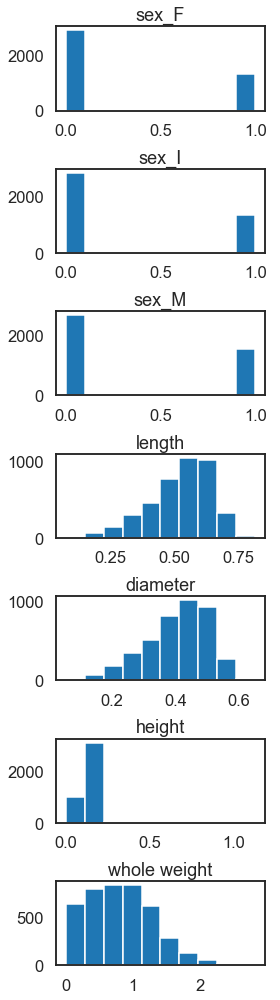

In [8]:
# defining features and labels
labels = ['rings','price']
features = [col for col in data.columns if col not in labels]
X = data[features]

plt.figure(figsize=[4,len(features)*2])
for i in range(len(features)):
    plt.subplot(len(features),1,i+1)
    plt.title(features[i])
    plt.hist(X[features[i]])
plt.tight_layout()

# setting profit and welfare targets to be centered
data['profit'] = data['price'] - np.mean(data['price'])

# welfare is a monotonic transform of age, where differences on the extremes matter less (todo maybe log is better)
def sigmoid(x, s=.1):
    return 1 / (1 + np.exp(-s*x))

data['welfare'] = (np.log((data['rings']+1.5)/ 10))
# normalize so profit and welfare have the same stddev
data['welfare'] = np.std(data['profit']) / np.std(data['welfare']) * data['welfare']
ys = data[['profit','welfare']]


In [9]:
print(np.mean(data['welfare']))
print(np.std(data['welfare']))
print()
print(np.mean(data['profit']))
print(np.std(data['profit']))

8.075427430171287
22.770246268458703

-7.473967179727948e-14
22.770246268458795


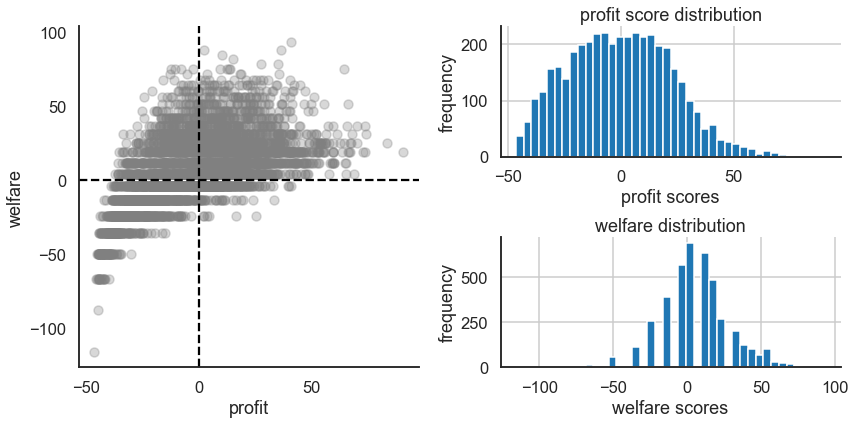

In [10]:
# Plotting spread of profit and welfare

plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.scatter(data['profit'].values, data['welfare'].values,  alpha=0.3, color='gray')
plt.axhline(0, ls = "--", color="black")
plt.axvline(0,  ls = "--", color="black")
sns.despine()

plt.xlabel('profit'); plt.ylabel('welfare')

plt.subplot(2,2,2)
data['profit'].hist(bins=40); plt.title('profit score distribution')
plt.xlabel('profit scores')
plt.ylabel('frequency')

sns.despine()
plt.subplot(2,2,4)
data['welfare'].hist(bins=40); plt.title('welfare distribution')
plt.xlabel('welfare scores')
plt.ylabel('frequency')

sns.despine()
plt.tight_layout()



plt.savefig('../icml/figures/abalone_score_dists.pdf')



In [11]:
print(np.corrcoef(data['profit'],data['welfare'])[0,1])

0.5645982094493756


## Defining Regression Routine

In [12]:
def run_outer_kfold(X_full, w_full, p_full, sigma_w=0, sigma_p=0, subset_frac = 1.0):
    preds_w_reg = []
    preds_p_reg = []
    preds_w_forest = []
    preds_p_forest = []
    test_idxs_outer = []
    train_set_sizes = []
    rs = np.random.RandomState(0)
    num_folds_outer = 5
    kf_outer = KFold(n_splits=num_folds_outer, random_state=rs,shuffle=True)

        
    for i, (train_idxs, test_idxs) in enumerate(kf_outer.split(X_full)):
        print("on {0} of {1}".format(i, num_folds_outer))

        if subset_frac < 1.0:
            train_idxs = train_idxs[:int(len(train_idxs)*subset_frac)]
            print("training data size: ", len(train_idxs))
            
        train_set_sizes.append(len(train_idxs))    
        test_idxs_outer.append(test_idxs)
        noise_w = sigma_w**2*np.random.randn(len(train_idxs))
        noise_p = sigma_p**2*np.random.randn(len(train_idxs))

        reg_w = get_model(X_full[train_idxs], w_full[train_idxs]+noise_w, method='linreg', cross_val=True)
        reg_p = get_model(X_full[train_idxs], p_full[train_idxs]+noise_p, method='linreg', cross_val=True)

        pred_w_reg = reg_w.predict(X_full[test_idxs])
        pred_p_reg = reg_p.predict(X_full[test_idxs])
        # keep track
        preds_w_reg.append(pred_w_reg)
        preds_p_reg.append(pred_p_reg)
    
        print("reg profit error: ",sklearn.metrics.mean_absolute_error(p_full[test_idxs], pred_p_reg))
        print("reg welfare error: ",sklearn.metrics.mean_absolute_error(w_full[test_idxs], pred_w_reg))

        forest_w_2 = get_model(X_full[train_idxs], w_full[train_idxs]+noise_w, method='randfor', crit="mse",
                       cross_val=True)
        forest_p_2 = get_model(X_full[train_idxs], p_full[train_idxs]+noise_p, method='randfor', crit="mse",
                       cross_val=True)

        pred_w_forest_2 = forest_w_2.predict(X_full[test_idxs])
        pred_p_forest_2 = forest_p_2.predict(X_full[test_idxs])
        # keep track
        preds_w_forest.append(pred_w_forest_2)
        preds_p_forest.append(pred_p_forest_2)
    
        print("forest profit error: ", sklearn.metrics.mean_absolute_error(p_full[test_idxs], pred_p_forest_2))
        print("forest welfare error: ", sklearn.metrics.mean_absolute_error(w_full[test_idxs], pred_w_forest_2))

    return {
        "preds_w_reg": preds_w_reg,
        "preds_p_reg": preds_p_reg,
        "preds_w_forest": preds_w_forest,
        "preds_p_forest": preds_p_forest,
        "test_idxs_outer": test_idxs_outer,
        "train_set_sizes": train_set_sizes
    }

# Degrading data by subsetting features

In [13]:

features_all = features.copy()

X_full = data[features].values
w_full = data['welfare'].values
p_full = data['profit'].values

preds_all_features = run_outer_kfold(X_full, w_full, p_full)

features_just_weight = ['whole weight']
X_weight = data[features_just_weight].values
preds_just_weight = run_outer_kfold(X_weight, w_full, p_full)

features_just_length = ['length']
X_length = data[features_just_length].values
preds_just_length = run_outer_kfold(X_length, w_full, p_full)

preds_by_features = [preds_just_length,
                     preds_just_weight, 
                     preds_all_features]


on 0 of 5
chosen lambda:  0.1
chosen lambda:  0.1
reg profit error:  2.027539351204011
reg welfare error:  12.402232962955324
chosen number of trees:  400
chosen depth:  4
chosen number of trees:  400
chosen depth:  8
forest profit error:  1.8417188230529449
forest welfare error:  12.1471373101261
on 1 of 5
chosen lambda:  1.0
chosen lambda:  1.0
reg profit error:  2.010810580817139
reg welfare error:  12.529686354458006
chosen number of trees:  400
chosen depth:  4
chosen number of trees:  400
chosen depth:  8
forest profit error:  1.8310552091545198
forest welfare error:  11.847122322786143
on 2 of 5
chosen lambda:  1.0
chosen lambda:  1.0
reg profit error:  1.9427231827111293
reg welfare error:  12.854793123578947
chosen number of trees:  400
chosen depth:  8
chosen number of trees:  200
chosen depth:  8
forest profit error:  1.7547791161627937
forest welfare error:  12.342928676679984
on 3 of 5
chosen lambda:  1.0
chosen lambda:  1.0
reg profit error:  2.0509250035891182
reg welfar

In [14]:
styles = [
         (0,(1,1)),
         '--',
          '-'
         ]

feats = ['length',
         'weight',
         'all features']


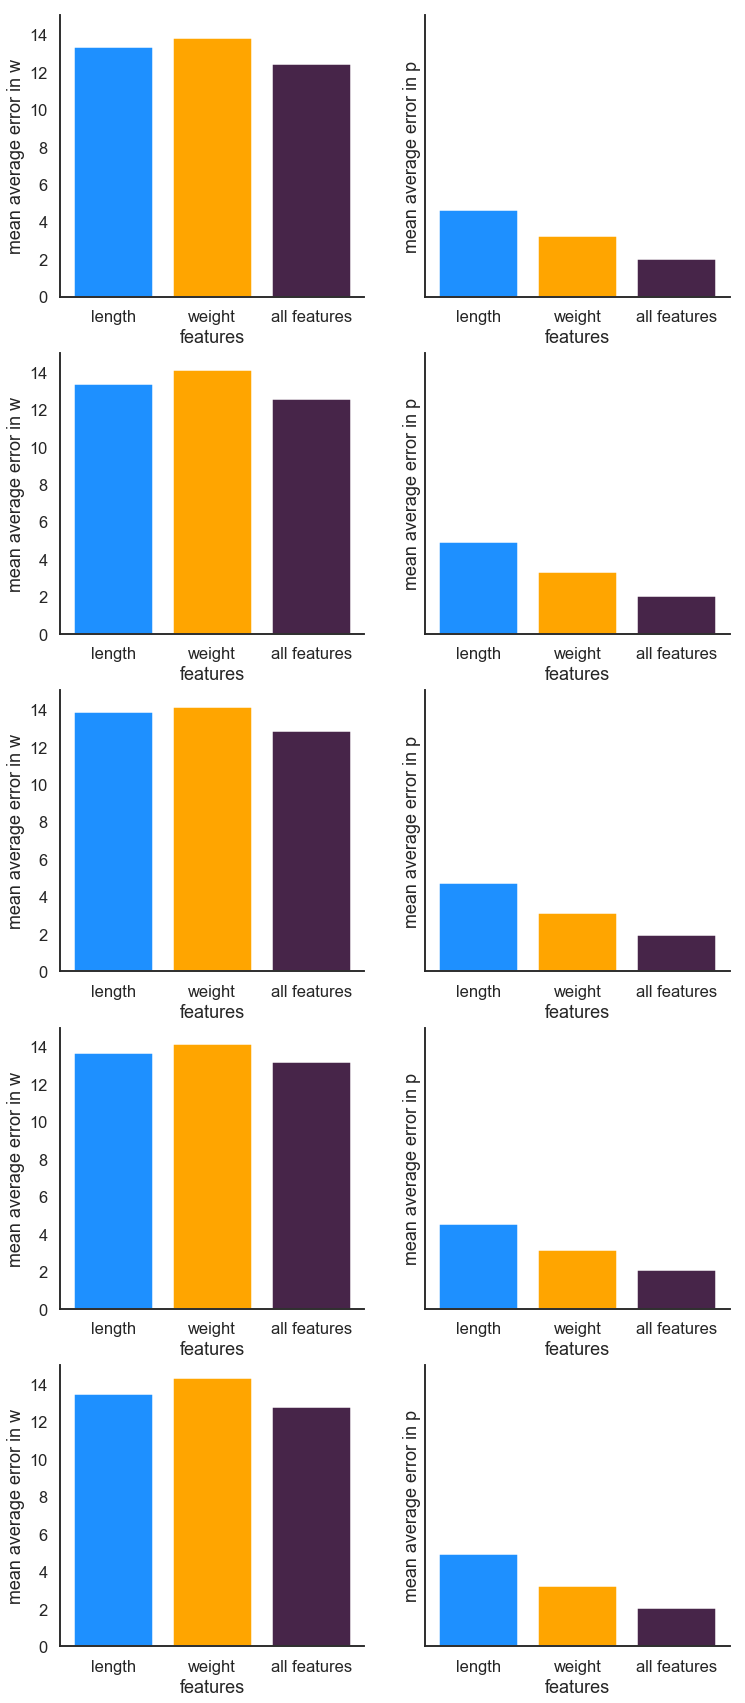

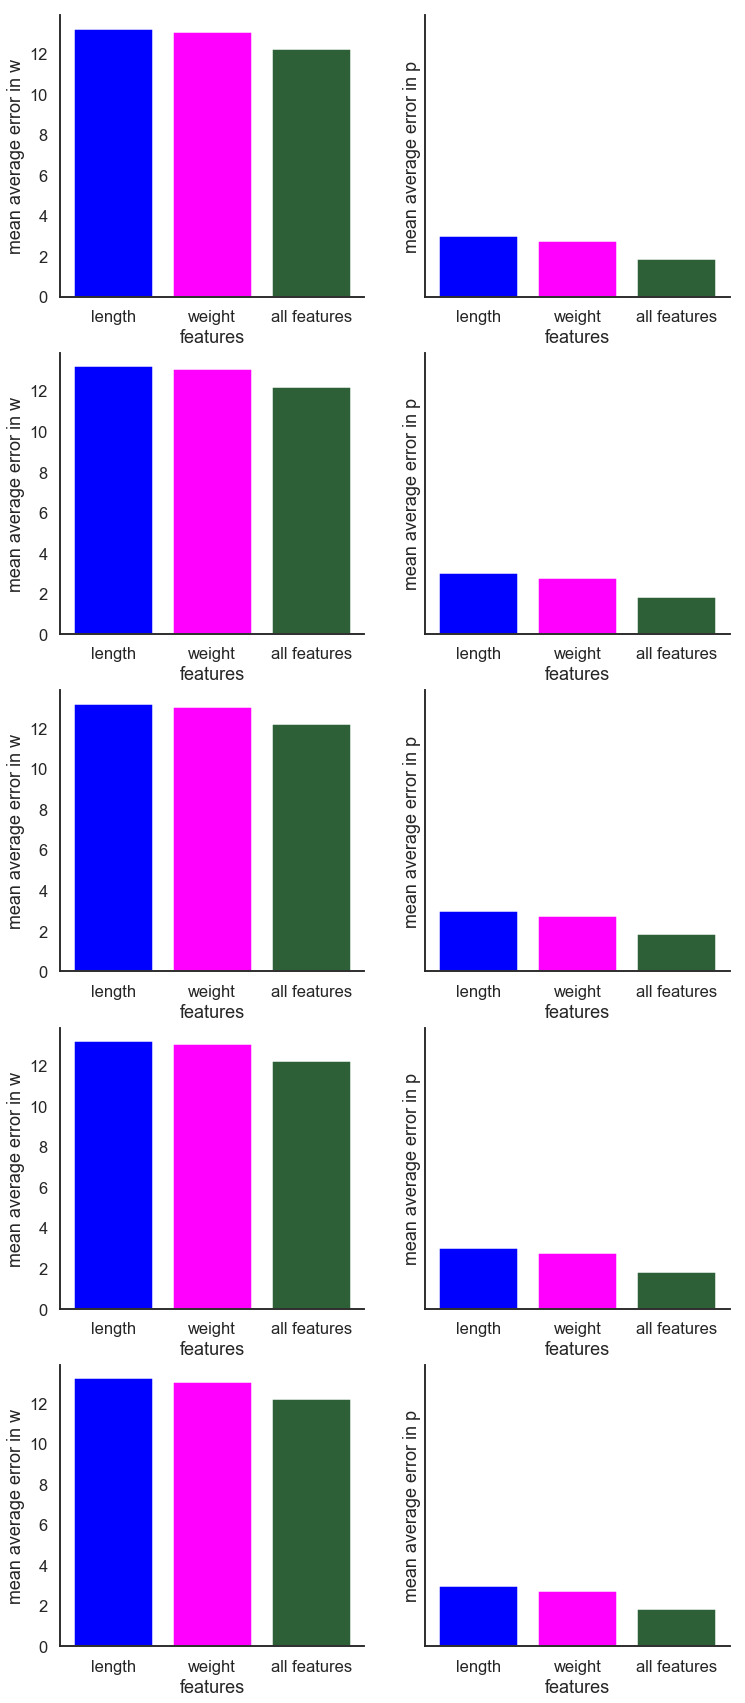

In [15]:
num_folds = 5
scale = 6
fig, ax = plt.subplots(num_folds,2,figsize=(2*scale,num_folds*scale),sharey=True)

for i in range(num_folds):  
    
    errs_w_reg, errs_w_for = np.zeros(3), np.zeros(3)
    errs_p_reg, errs_p_for = np.zeros(3), np.zeros(3)
    
    for p, preds_this in enumerate(preds_by_features):
        test_idxs = preds_this["test_idxs_outer"][i]
               
        pred_w_reg = preds_this["preds_w_reg"][i]
        pred_p_reg = preds_this["preds_p_reg"][i]
    
        pred_w_forest =  preds_this["preds_w_forest"][i]
        pred_p_forest =  preds_this["preds_p_forest"][i]
        
        errs_w_reg[p] = sklearn.metrics.mean_absolute_error(w_full[test_idxs], pred_w_reg) 
        errs_p_reg[p] = sklearn.metrics.mean_absolute_error(p_full[test_idxs], pred_p_reg) 
        errs_w_for[p] = sklearn.metrics.mean_absolute_error(w_full[test_idxs], pred_w_forest) 
        errs_p_for[p] = sklearn.metrics.mean_absolute_error(p_full[test_idxs], pred_p_forest) 
    
    ax[i,0].bar(feats, errs_w_reg, color=colors_feats_reg)
    #ax[i,0].set_title(' ridge regression model')
    ax[i,0].set_ylabel('mean average error in w')
    ax[i,0].set_xlabel('features')
    
    ax[i,1].bar(feats, errs_p_reg, color=colors_feats_reg)
    #ax[i,1].set_title(' ridge regression model')
    ax[i,1].set_ylabel('mean average error in p')
    ax[i,1].set_xlabel('features')
    sns.despine()
        

plt.savefig('../icml/figures/abalone_errors_ridge_d.pdf', bbox_inches='tight')

fig, ax = plt.subplots(num_folds,2,figsize=(2*scale,num_folds*scale),sharey=True)


for i in range(num_folds):  
    ax[i,0].bar(feats, errs_w_for, color=colors_feats_for)
    #ax[i,0].set_title(' random forest model')
    ax[i,0].set_ylabel('mean average error in w')
    ax[i,0].set_xlabel('features')
    
    ax[i,1].bar(feats, errs_p_for, color=colors_feats_for)
    #ax[i,1].set_title(' random forest model')
    ax[i,1].set_ylabel('mean average error in p')
    ax[i,1].set_xlabel('features')
    
    sns.despine()
        

plt.savefig('abalone_errors_forest_d.pdf', bbox_inches='tight')
        
        

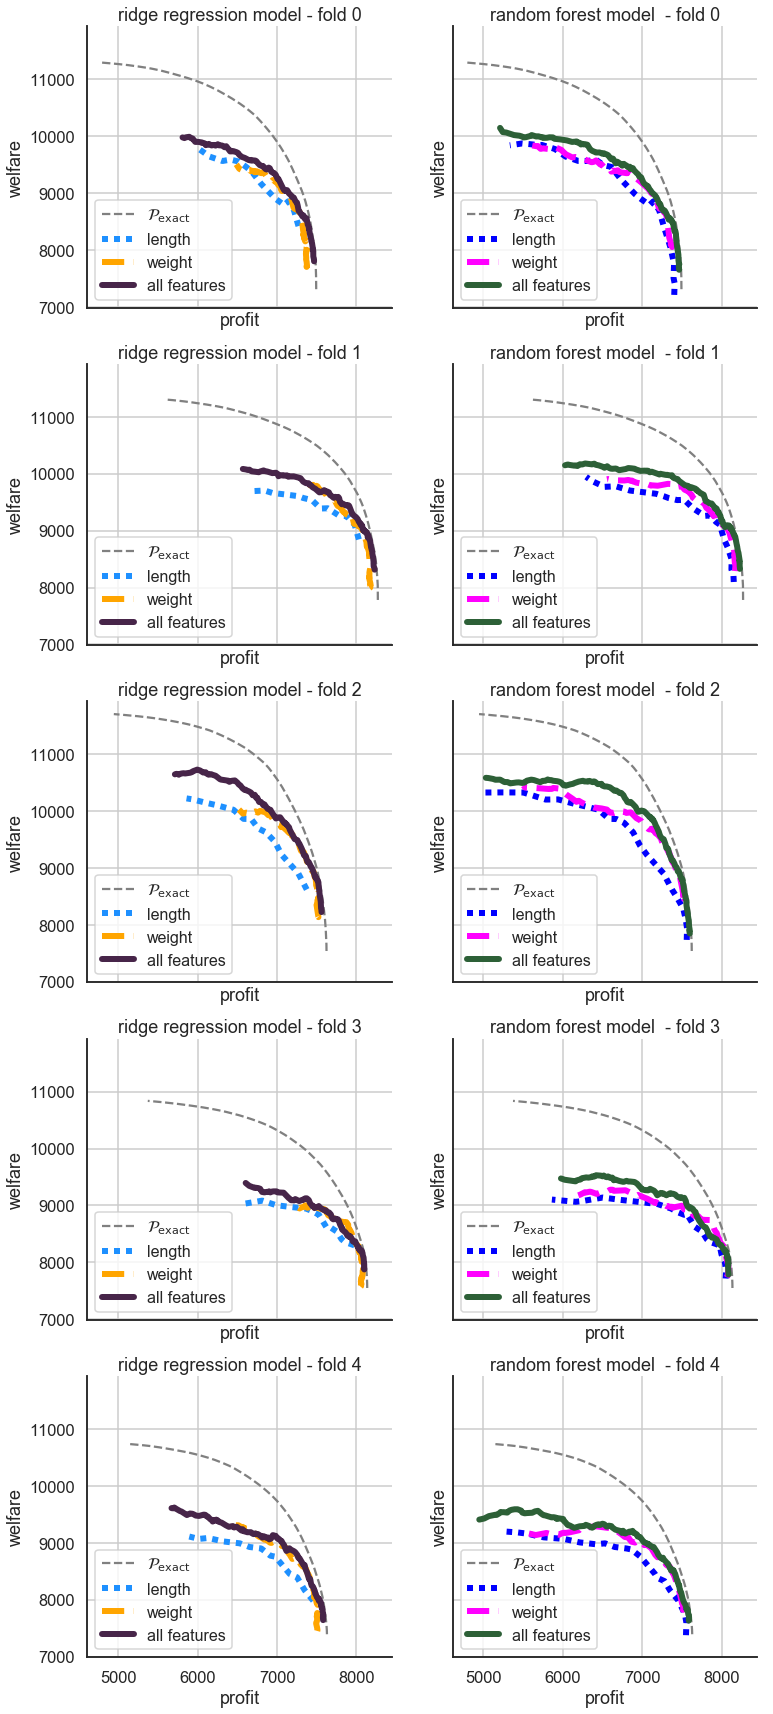

In [16]:
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

num_folds = 5

scale = 6

fig, ax = plt.subplots(num_folds,2,figsize=(2*scale,num_folds*scale),sharey=True,sharex=True)

for p, preds_this in enumerate(preds_by_features):
    for i in range(num_folds):  
        test_idxs = preds_this["test_idxs_outer"][i]
               
        pred_w_reg = preds_this["preds_w_reg"][i]
        pred_p_reg = preds_this["preds_p_reg"][i]
    
        pred_w_forest =  preds_this["preds_w_forest"][i]
        pred_p_forest =  preds_this["preds_p_forest"][i]
    
        pr_reg = compute_pareto_curves(pred_w_reg, pred_p_reg, w_full[test_idxs], p_full[test_idxs])
        pr_forest = compute_pareto_curves(pred_w_forest, pred_p_forest, w_full[test_idxs], p_full[test_idxs])

        alphas = pr_forest['alphas']
        if p == 0:
            ax[i,0].plot(pr_forest['U_p_opt'],pr_forest['U_w_opt'], color='grey', ls='--', label=pareto_exact)
            ax[i,1].plot(pr_forest['U_p_opt'],pr_forest['U_w_opt'], color='grey', ls='--', label=pareto_exact)
        
        ax[i,0].plot(pr_reg['U_p_model'],pr_reg['U_w_model'], 
                   color=colors_feats_reg[p],
                   ls = styles[p],
                     lw=6,
                   label=feats[p])
        ax[i,1].plot(pr_forest['U_p_model'],pr_forest['U_w_model'],
                   color=colors_feats_for[p], 
                   ls = styles[p],
                     lw=6,
                   label=feats[p])
    

        ax[i,0].set_xlabel('profit')
        ax[i,0].set_ylabel('welfare')
        
        ax[i,1].set_xlabel('profit')
        ax[i,1].set_ylabel('welfare')

        ax[i,0].legend(prop={'size': 16})
        ax[i,1].legend(prop={'size': 16})

            
        ax[i,0].set_title('ridge regression model - fold {0}'.format(i))
        ax[i,1].set_title('random forest model  - fold {0}'.format(i))
    

        ax[i,0].grid(b=True, which='major')
        ax[i,1].grid(b=True, which='major')

        sns.despine(left=False)

plt.savefig('abalone_d_all_folds.pdf',bbox_inches='tight')

# Degrading data by reducing number of training points.

In [17]:
X_full = data[features].values
w_full = data['welfare'].values
p_full = data['profit'].values

n_full = X_full.shape[0]

preds_by_subset_frac = []
for subset_frac in subset_fracs:
    
    preds_this_frac =  run_outer_kfold(X_full, w_full, p_full, subset_frac=subset_frac)
    preds_by_subset_frac.append(preds_this_frac)

on 0 of 5
training data size:  16
chosen lambda:  10.0
chosen lambda:  0.001
reg profit error:  2.5618438117282287
reg welfare error:  17.02611626824995
chosen number of trees:  200
chosen depth:  4
chosen number of trees:  200
chosen depth:  4
forest profit error:  4.7840022989035065
forest welfare error:  14.654458179387108
on 1 of 5
training data size:  16
chosen lambda:  10.0
chosen lambda:  0.001
reg profit error:  2.388907738306555
reg welfare error:  16.109864846514558
chosen number of trees:  400
chosen depth:  8
chosen number of trees:  200
chosen depth:  4
forest profit error:  4.864168602269889
forest welfare error:  12.987958816401141
on 2 of 5
training data size:  16
chosen lambda:  0.0001
chosen lambda:  0.0001
reg profit error:  2.762785157129488
reg welfare error:  16.663484907046833
chosen number of trees:  400
chosen depth:  8
chosen number of trees:  200
chosen depth:  4
forest profit error:  3.9111821029940086
forest welfare error:  14.469305151499709
on 3 of 5
trai

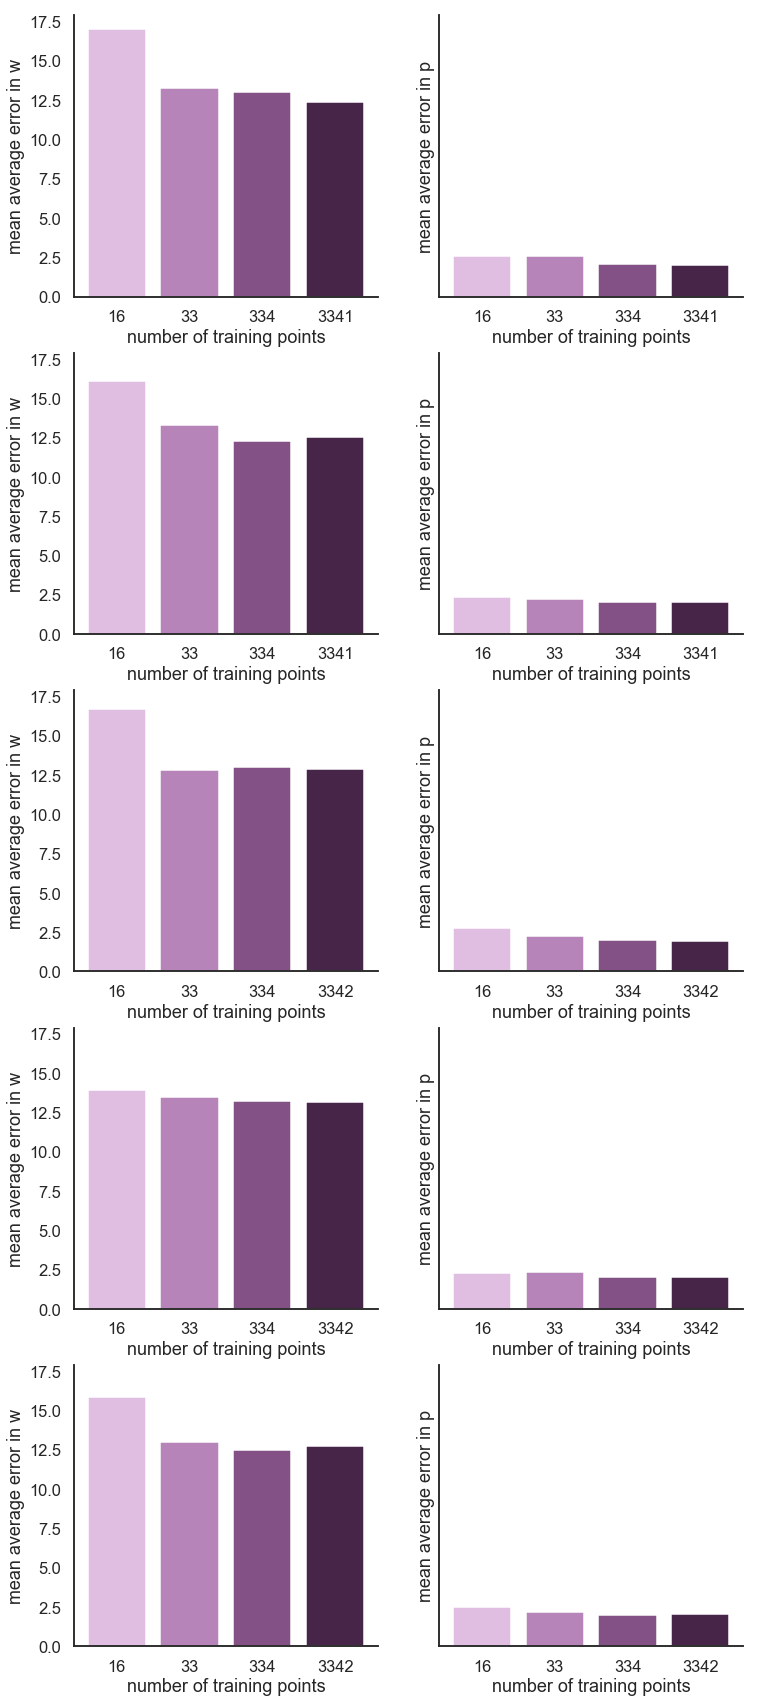

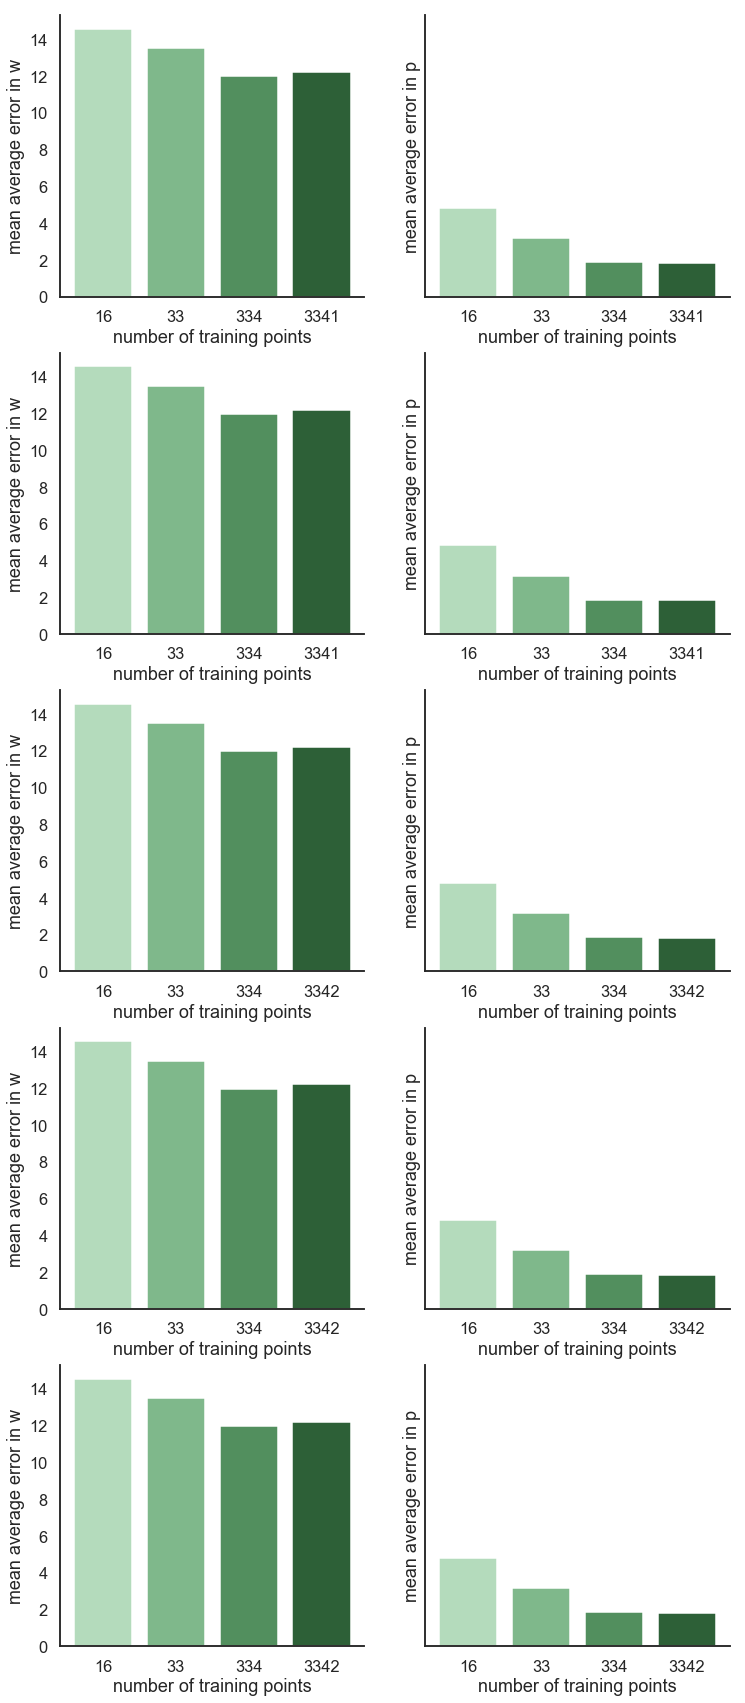

In [18]:
fig, ax = plt.subplots(num_folds,2,figsize=(2*scale,num_folds*scale),sharey=True)

num_fracs = len(preds_by_subset_frac)

ns = np.zeros((num_folds, num_fracs))

for i in range(num_folds):  
    
    errs_w_reg, errs_w_for = np.zeros(num_fracs), np.zeros(num_fracs)
    errs_p_reg, errs_p_for = np.zeros(num_fracs), np.zeros(num_fracs)
    
    for p, preds_this in enumerate(preds_by_subset_frac):
        test_idxs = preds_this["test_idxs_outer"][i]
        num_training_points = preds_this['train_set_sizes'][i]
        
        ns[i,p] = num_training_points
               
        pred_w_reg = preds_this["preds_w_reg"][i]
        pred_p_reg = preds_this["preds_p_reg"][i]
    
        pred_w_forest =  preds_this["preds_w_forest"][i]
        pred_p_forest =  preds_this["preds_p_forest"][i]
        
        errs_w_reg[p] = sklearn.metrics.mean_absolute_error(w_full[test_idxs], pred_w_reg) 
        errs_p_reg[p] = sklearn.metrics.mean_absolute_error(p_full[test_idxs], pred_p_reg) 
        errs_w_for[p] = sklearn.metrics.mean_absolute_error(w_full[test_idxs], pred_w_forest) 
        errs_p_for[p] = sklearn.metrics.mean_absolute_error(p_full[test_idxs], pred_p_forest) 
    
    ax[i,0].bar([str(int(x)) for x in ns[i]], errs_w_reg, color=purple_colors)
    #ax[i,0].set_title(' ridge regression model')
    ax[i,0].set_ylabel('mean average error in w')
    ax[i,0].set_xlabel('number of training points')
    
    ax[i,1].bar([str(int(x)) for x in ns[i]], errs_p_reg, color=purple_colors)
    #ax[i,1].set_title(' ridge regression model')
    ax[i,1].set_ylabel('mean average error in p')
    ax[i,1].set_xlabel('number of training points')
    sns.despine()
        

plt.savefig('../icml/figures/abalone_errors_ridge_n.pdf', bbox_inches='tight')

fig, ax = plt.subplots(num_folds,2,figsize=(2*scale,num_folds*scale),sharey=True)


for i in range(num_folds):  
    ax[i,0].bar([str(int(x)) for x in ns[i]], errs_w_for, color=green_colors)
    #ax[i,0].set_title(' random forest model')
    ax[i,0].set_ylabel('mean average error in w')
    ax[i,0].set_xlabel('number of training points')
    
    ax[i,1].bar([str(int(x)) for x in ns[i]], errs_p_for, color=green_colors)
    #ax[i,1].set_title(' random forest model')
    ax[i,1].set_ylabel('mean average error in p')
    ax[i,1].set_xlabel('number of training points')
    
    sns.despine()
        

plt.savefig('../icml/figures/abalone_errors_forest_n.pdf', bbox_inches='tight')

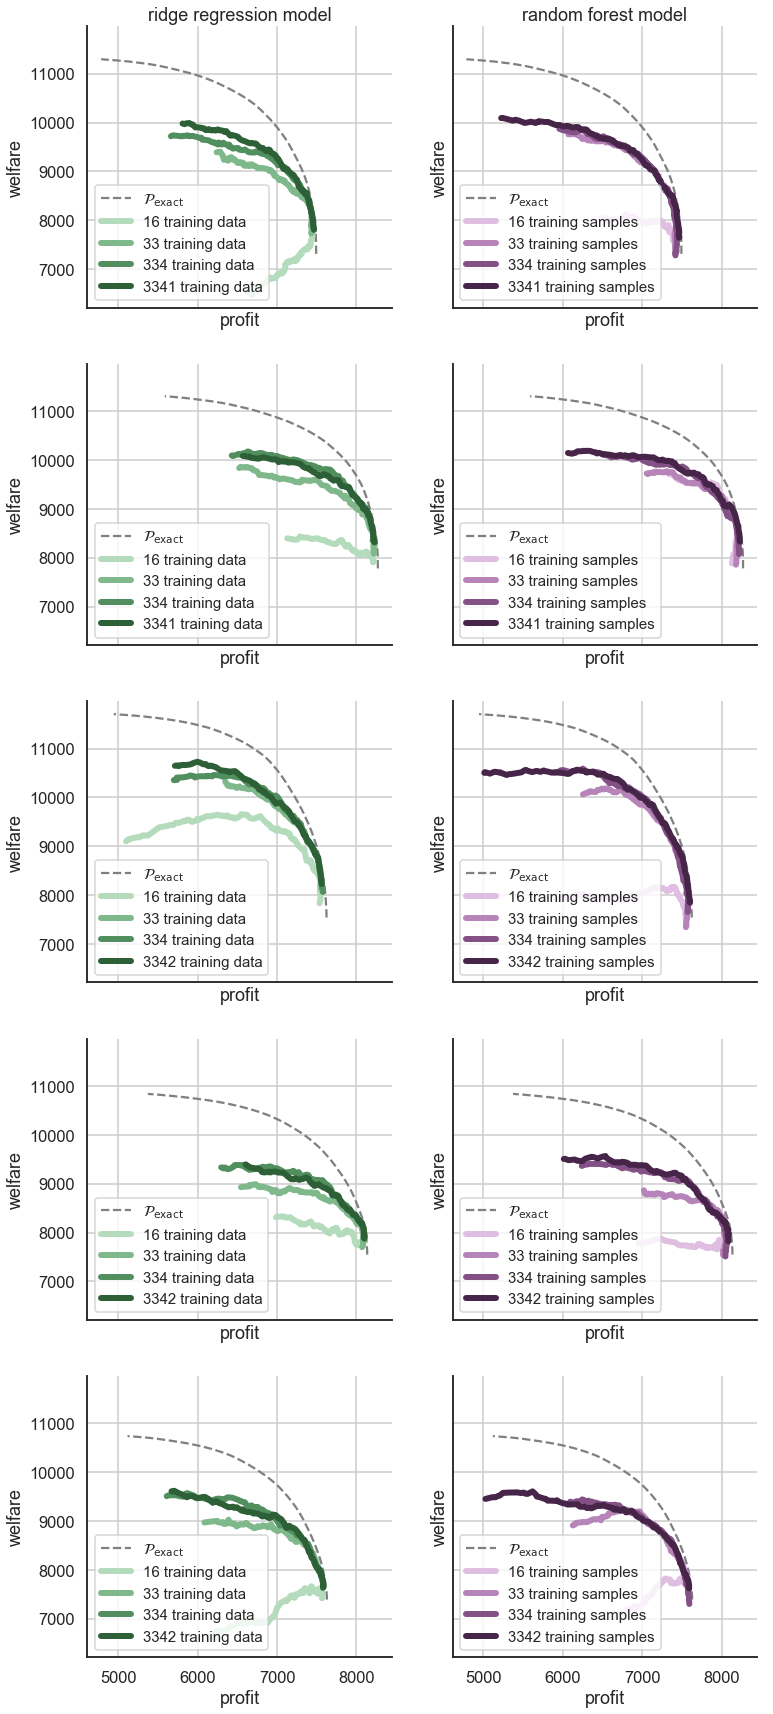

In [19]:
import seaborn as sns
sns.set_context('talk')

num_folds = 5
scale = 6

fig, ax = plt.subplots(num_folds,2,figsize=(2*scale,num_folds*scale),sharey=True,sharex=True)
   

for p, preds_this in enumerate(preds_by_subset_frac):
    for i in range(num_folds):  
        
        num_training_points = preds_this['train_set_sizes'][i]
        test_idxs = preds_this["test_idxs_outer"][i]
               
        pred_w_reg = preds_this["preds_w_reg"][i]
        pred_p_reg = preds_this["preds_p_reg"][i]
    
        pred_w_forest =  preds_this["preds_w_forest"][i]
        pred_p_forest =  preds_this["preds_p_forest"][i]
    
        pr_reg = compute_pareto_curves(pred_w_reg, pred_p_reg, w_full[test_idxs], p_full[test_idxs])
        pr_forest = compute_pareto_curves(pred_w_forest, pred_p_forest, w_full[test_idxs], p_full[test_idxs])

        alphas = pr_forest['alphas']
        if p == 0:
            ax[i,0].plot(pr_forest['U_p_opt'],pr_forest['U_w_opt'], color='grey', ls='--', label=pareto_exact)
            ax[i,1].plot(pr_forest['U_p_opt'],pr_forest['U_w_opt'], color='grey', ls='--', label=pareto_exact)
        
        ax[i,0].plot(pr_reg['U_p_model'],pr_reg['U_w_model'], 
                   color=green_colors[p], 
                   lw=6,
                   label='{0} training data'.format(num_training_points))
        ax[i,1].plot(pr_forest['U_p_model'],pr_forest['U_w_model'],
                   color=purple_colors[p], 
                   lw=6,
                     #ls = styles[p],
                   label='{0} training samples'.format(num_training_points))
    

        ax[i,0].set_xlabel('profit')
        ax[i,0].set_ylabel('welfare')
        
        ax[i,1].set_xlabel('profit')
        ax[i,1].set_ylabel('welfare')
        
        ax[i,0].legend(prop={'size': 15})#bbox_to_anchor = (1,2))
        ax[i,1].legend(prop={'size': 15})#bbox_to_anchor = (1,2))
        #ax[i.0].set_title('ri')
        
        # add gridlines
        ax[i,0].grid(b=True, which='major')
        ax[i,1].grid(b=True, which='major')
    
    ax[0,0].set_title('ridge regression model')
    ax[0,1].set_title('random forest model')
        
    sns.despine()
    
plt.savefig('../icml/figures/abalone_n_all_folds.pdf',bbox_inches='tight')

# Plotting fold 0 of each for main paper figures.

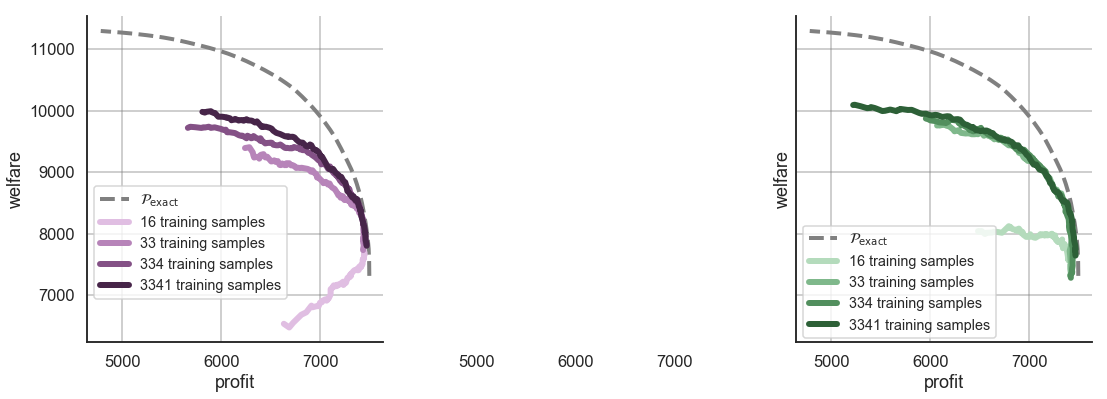

In [20]:
# compile the figures for the paper -- each result it's on figure
scale = 6
sns.set_context('talk')

legend_fontsize = 16
i = 0
# plot returns to additional data

fig, [ax_reg, ax_empty, ax_for]  = plt.subplots(1,3,figsize=(3*scale,scale), sharex=True, sharey=True)

for p, preds_this in enumerate(preds_by_subset_frac):
    # use first fold only
    test_idxs = preds_this["test_idxs_outer"][i]
    num_training_points = preds_this['train_set_sizes'][i]
    
    pred_w_reg = preds_this["preds_w_reg"][i]
    pred_p_reg = preds_this["preds_p_reg"][i]
    
    pr_reg = compute_pareto_curves(pred_w_reg, pred_p_reg, w_full[test_idxs], p_full[test_idxs])

    alphas = pr_reg['alphas']
    if p == 0:
        # put optimal on 
        ax_reg.plot(pr_reg['U_p_opt'],pr_reg['U_w_opt'], color='grey', 
                    lw = 4, 
                    ls='--', label=pareto_exact)
        
    ax_reg.plot(pr_reg['U_p_model'],pr_reg['U_w_model'], 
                color=purple_colors[p], 
                   lw=6,
                   label='{0} training samples'.format(num_training_points,
                                                               (100*subset_fracs[p])))
    
        
    ax_reg.set_xlabel('profit')
    ax_reg.set_ylabel('welfare')
    ax_reg.legend(prop={'size': legend_fontsize*.9},
                 bbox_to_anchor=(.7,.5)) 
ax_reg.grid(b=True, which='major',color='gray',alpha=.5) 

sns.despine(ax=ax_reg)    

    
#fig_for, ax_for = plt.subplots(figsize=(scale,scale))

for p, preds_this in enumerate(preds_by_subset_frac):
    # use first fold only
    test_idxs = preds_this["test_idxs_outer"][i]
    num_training_points = preds_this['train_set_sizes'][i]
    
    pred_w_forest =  preds_this["preds_w_forest"][i]
    pred_p_forest =  preds_this["preds_p_forest"][i]
    
    pr_forest = compute_pareto_curves(pred_w_forest, pred_p_forest, w_full[test_idxs], p_full[test_idxs])

    alphas = pr_forest['alphas']
    if p == 0:
        # put optimal on
        ax_for.plot(pr_forest['U_p_opt'],pr_forest['U_w_opt'], color='grey', 
                    lw = 4, ls='--', label=pareto_exact)
        
    ax_for.plot(pr_forest['U_p_model'],pr_forest['U_w_model'],
                   color=green_colors[p], 
                   lw=6,
                    #ls = styles[p],
                   label='{0} training samples'.format(num_training_points,
                                                               (100*subset_fracs[p])))
    

    
        
    ax_for.set_xlabel('profit')
    ax_for.set_ylabel('welfare')
    ax_for.legend(prop={'size': legend_fontsize*.9},
                  bbox_to_anchor=(.7,.38)) 
    

#ax_for.set_yticks(ax_reg.get_yticks())
ax_for.grid(b=True, which='major',color='gray',alpha=.5) 

sns.despine(ax=ax_for)     

# remove the middle axes so figures save independently
sns.despine(ax=ax_empty, left=True, bottom=True)

# save individual axes as individual plots
extent_reg = ax_reg.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
extent_for = ax_for.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

plt.savefig('../icml/figures/abalone_n_reg.pdf',bbox_inches=extent_reg.expanded(1.4, 1.3))
plt.savefig('../icml/figures/abalone_n_for.pdf',bbox_inches=extent_for.expanded(1.1, 1.3))

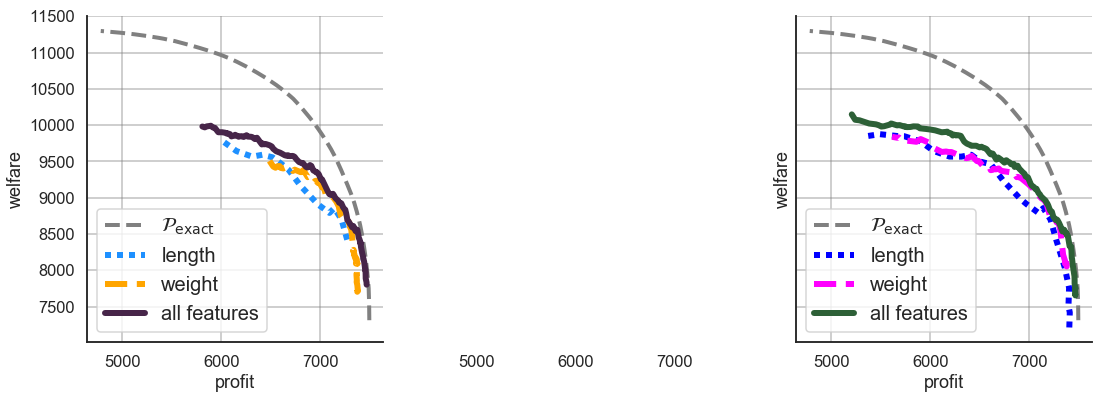

In [21]:
# plot returns to features
fig, [ax_reg, ax_empty, ax_for]  = plt.subplots(1,3,figsize=(3*scale,scale), sharex=True, sharey=True)

legend_fontsize=20
for p, preds_this in enumerate([preds_all_features, 
                                preds_just_weight, 
                                preds_just_length,
                               # preds_just_sex
                               ][::-1]):
    
    test_idxs = preds_this["test_idxs_outer"][i]
    
               
    pred_w_reg = preds_this["preds_w_reg"][i]
    pred_p_reg = preds_this["preds_p_reg"][i]

    pr_reg = compute_pareto_curves(pred_w_reg, pred_p_reg, w_full[test_idxs], p_full[test_idxs])

    alphas = pr_forest['alphas']
    if p == 0:
        ax_reg.plot(pr_reg['U_p_opt'],pr_reg['U_w_opt'], color='grey', ls='--', lw=4,label=pareto_exact)
        
    ax_reg.plot(pr_reg['U_p_model'],pr_reg['U_w_model'], 
                   color=colors_feats_reg[p], 
                   ls = styles[p],
                     lw=6,
                   label=feats[p])

    

    ax_reg.set_xlabel('profit')
    ax_reg.set_ylabel('welfare')
        
    ax_reg.grid(b=True, which='major',color='grey', alpha=0.5)
     
ax_reg.legend(prop={'size': legend_fontsize})        
sns.despine(ax=ax_reg)

plt.savefig("../icml/figures/abalone_d_reg.pdf",bbox_inches='tight')




colors_feats = ['orange', 'cyan', all_training_data_color_for]

for p, preds_this in enumerate([preds_all_features, 
                                preds_just_weight, 
                                preds_just_length,
                               # preds_just_sex
                               ][::-1]):
    test_idxs = preds_this["test_idxs_outer"][i]
    
               
    pred_w_forest =  preds_this["preds_w_forest"][i]
    pred_p_forest =  preds_this["preds_p_forest"][i]
    
    pr_forest = compute_pareto_curves(pred_w_forest, pred_p_forest, w_full[test_idxs], p_full[test_idxs])

    alphas = pr_forest['alphas']
    if p == 0:
        ax_for.plot(pr_forest['U_p_opt'],pr_forest['U_w_opt'], color='grey', ls='--', lw=4, label=pareto_exact)
        
    ax_for.plot(pr_forest['U_p_model'],pr_forest['U_w_model'],
                   color= colors_feats_for[p], 
                   ls = styles[p],
                     lw=6,
                   label= feats[p])
    

ax_for.set_xlabel('profit')
ax_for.set_ylabel('welfare')
        
ax_for.legend(prop={'size': legend_fontsize}) #,bbox_to_anchor=(0.45,0.35))
            
    
#ax_for.set_yticks(np.linspace(8000,11100, 1000))
ax_for.grid(b=True, which='major',color='grey', alpha=0.5)
    
        
sns.despine(ax=ax_for)

# remove the middle axes so figures save independently
sns.despine(ax=ax_empty, left=True, bottom=True)

extent_reg = ax_reg.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
extent_for = ax_for.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

plt.savefig('../icml/figures/abalone_d_reg.pdf',bbox_inches=extent_reg.expanded(1.4, 1.3))
plt.savefig('../icml/figures/abalone_d_for.pdf',bbox_inches=extent_for.expanded(1.4, 1.3))